<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_Pytorch_Wasserstein_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement [Wasserstein GAN](https://https://arxiv.org/pdf/1701.07875.pdf) from the paper with the same name, written by Martin Arjovsky, Soumith Chintala and L´eon Bottou.

Pros of WGAN:
*   Stabler than DCGAN or GAN (preventing mode colapse)
*   Loss = Termination criteria (Loss means nothing much for DCGAN)




Up until now we have been using Jensen-Shannon (JS) divergence to define a distance between 2 probability distributions for GAN or DCGAN. But JS divergence has gradient issues which leads to unstability in training -> using Wasserstein to overcome the problem.

The dataset I use for this notebook and for other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU. 

# Setup

In [1]:
#Packages for GAN
import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch
import torchvision

# Supporting packages
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [15]:
#Hyperparameter as in paper
NUM_EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
Z_DIM = 100 
HIDDEN_DIM = 64
IMG_SIZE = 28
IM_CHANNELS = 1
DIM = 10
NUM_CRITIC = 5
WEIGHT_CLIP = 0.01
img_shape = (IM_CHANNELS, IMG_SIZE, IMG_SIZE) #1, 28,28

In [16]:
#checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Getting data

In [18]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)), #change values if not MNIST
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True)

# Generator

Actually Generator and Discriminator (Critic) are not diffirent from GAN. Just no Sigmoid() at the end of Discriminatior.

In [19]:
class Generator(nn.Module):
    def __init__(self,Z_DIM=100, HIDDEN_DIM=64, OUT_CHANNEL=1):
        super(Generator, self).__init__()
        def block_generator(Z_DIM, HIDDEN_DIM, normalize=True):
            layers = [nn.Linear(Z_DIM, HIDDEN_DIM)]
            if normalize:
                layers.append(nn.BatchNorm1d(HIDDEN_DIM, 0.8)) #should be used to get better output
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block_generator(Z_DIM, HIDDEN_DIM*2, normalize=False),
            *block_generator(HIDDEN_DIM*2, HIDDEN_DIM*4),
            *block_generator(HIDDEN_DIM*4, HIDDEN_DIM*8),
            *block_generator(HIDDEN_DIM*8, HIDDEN_DIM*16),
            nn.Linear(HIDDEN_DIM*16, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

# Discriminator / Critic

Discriminator no longer uses Sigmoid() at the end of the last layer, which allows output to be out of [0,1].
New name would be Critic! The Critic would be trained more than the Generator (n_critic = 5)

In [20]:
class Discriminator(nn.Module):
    def __init__(self,IM_CHANNEL=1, HIDDEN_DIM=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(IMG_SIZE** 2, HIDDEN_DIM*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(HIDDEN_DIM*8, HIDDEN_DIM*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(HIDDEN_DIM*4, 1),
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Training

In [21]:
# Initialize generator and discriminator
generator = Generator().to(device)
generator.train()

critic = Discriminator().to(device)
critic.train()

#As in paper using RMSprop instead of Adam Opt
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

Tensor = torch.cuda.FloatTensor if device == "cuda" else torch.FloatTensor

Also there is not many changes in the training process except for the #NEW: ...

In [22]:
batches_done = 0
saved_imgs = []
for epoch in range(NUM_EPOCHS):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        
        #Training Critic
        critic_optimizer.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], Z_DIM))))
        fake_imgs = generator(z).detach()
        
        critic_loss = torch.mean(critic(fake_imgs)) - torch.mean(critic(real_imgs)) 
        critic_loss.backward()
        critic_optimizer.step()
                
        #NEW: Clipping every weight parameter in the network to be between -0,01 and 0.01
        for p in critic.parameters():
            p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        
        #NEW: Traninig Generator
        if i % NUM_CRITIC == 0: 
                      
            generator_optimizer.zero_grad()
            critics_fake_imgs = generator(z)
            generator_loss = -torch.mean(critic(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=DIM)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)


Epoch 0 training... done, took 10.8 seconds.
Epoch 1 training... done, took 10.8 seconds.
Epoch 2 training... done, took 10.6 seconds.
Epoch 3 training... done, took 12.0 seconds.
Epoch 4 training... done, took 11.1 seconds.
Epoch 5 training... done, took 10.8 seconds.
Epoch 6 training... done, took 10.6 seconds.
Epoch 7 training... done, took 10.7 seconds.
Epoch 8 training... done, took 10.5 seconds.
Epoch 9 training... done, took 10.5 seconds.
Epoch 10 training... done, took 10.5 seconds.
Epoch 11 training... done, took 10.5 seconds.
Epoch 12 training... done, took 10.6 seconds.
Epoch 13 training... done, took 10.5 seconds.
Epoch 14 training... done, took 10.7 seconds.
Epoch 15 training... done, took 10.7 seconds.
Epoch 16 training... done, took 10.6 seconds.
Epoch 17 training... done, took 10.7 seconds.
Epoch 18 training... done, took 10.6 seconds.
Epoch 19 training... done, took 10.5 seconds.
Epoch 20 training... done, took 10.7 seconds.
Epoch 21 training... done, took 10.5 seconds

# Visualization

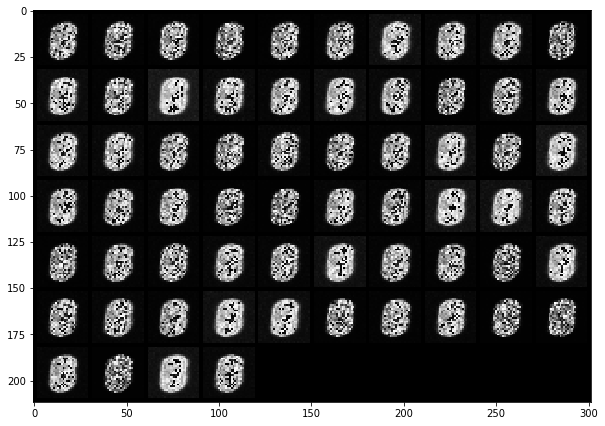

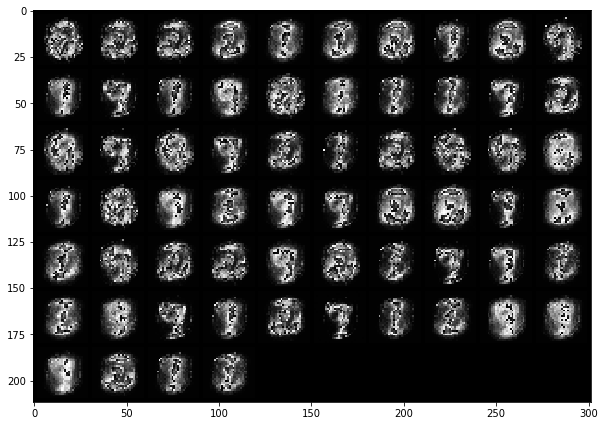

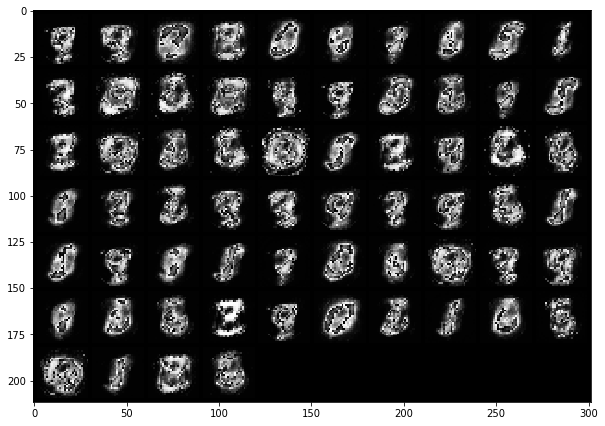

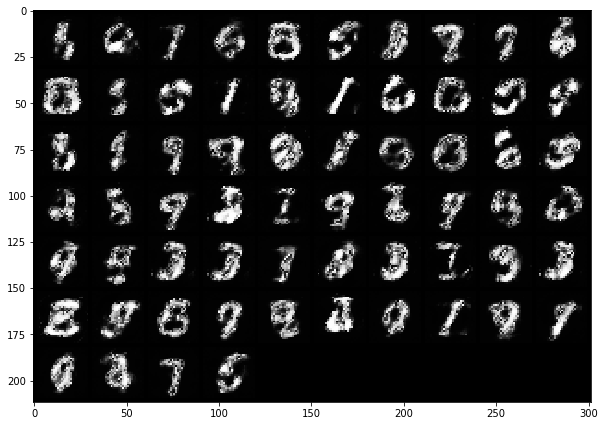

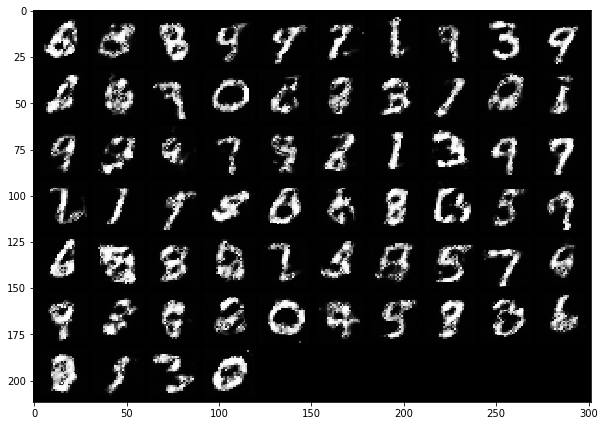

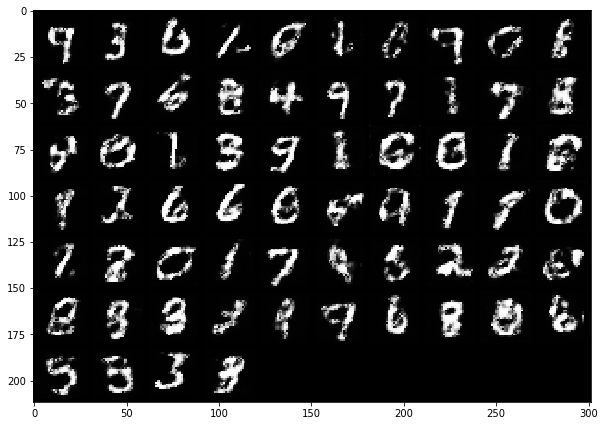

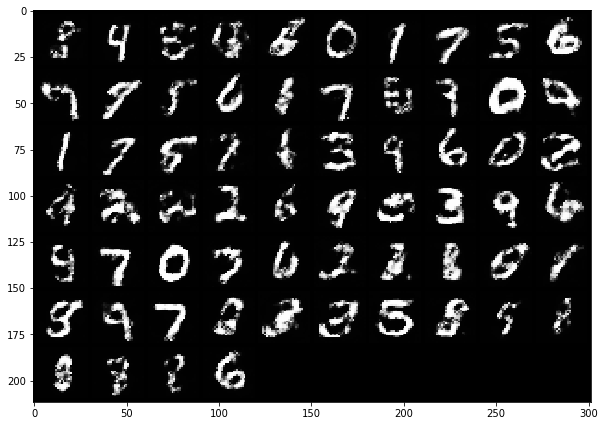

In [23]:
img_indexes = [0, 4, 9, 49, 99, 149, 199] 
for i in img_indexes:
    plt.figure(figsize = (DIM, DIM))
    plt.imshow(saved_imgs[i], interpolation='nearest')

# Summary

From the paper:


*   Meanningful loss metric that correlates with the generator's convergence and sample quality
*   Improved stability of the optimization process

There are also other structures for WGAN which works! 
This notebook use the structure of classic GAN because it is faster to show results :-)
The WGAN can be upgraded to WGAN with Gradient Penalty which uses Adam Optimizer and does not constraint the weights of the generator or critic in anyway.
Useful link:


*   [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf) (WGAN with Gradient Penalty)
*   [WGAN explaned](https://https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/) (lot of math but with good resources)
* Again, math, math, math but is a good source: [From GAN to WGAN](https://https://lilianweng.github.io/posts/2017-08-20-gan/)
* [GAN's challenges](https://https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/ch04.html) (Book chapter)